In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `train` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `train`


In [ ]:
rm -rf vit-deepfake-second-finetune

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

!pip install -q \
  torch torchvision \
  transformers==4.50.3 \
  datasets==3.5.0 \
  evaluate==0.4.3 \
  matplotlib \
  pillow==11.1.0

In [ ]:

from PIL import Image
from pathlib import Path
import random
import torch
import numpy as np
import evaluate
import logging
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers import (
    ViTImageProcessor,
    ViTForImageClassification,
    TrainingArguments,
    Trainer
)

from google.colab import drive, files
import os

logging.basicConfig(
    filename="training_log.txt",
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [ ]:
!pip install -q gdown
!pip install datasets

import gdown
import zipfile

# Download from Google Drive
file_id = "16jlun6sMcyPPmn8_tqseiphm9BHr0T61"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="dataset.zip", quiet=False)

# Unzip dataset
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")


Downloading...
From (original): https://drive.google.com/uc?id=16jlun6sMcyPPmn8_tqseiphm9BHr0T61
From (redirected): https://drive.google.com/uc?id=16jlun6sMcyPPmn8_tqseiphm9BHr0T61&confirm=t&uuid=459bd2cd-7c3b-4ad7-b13b-eefdfe896130
To: /content/dataset.zip
100%|██████████| 34.7M/34.7M [00:00<00:00, 177MB/s]


In [ ]:
from pathlib import Path
from PIL import Image
import random

def load_dataset_split(split_folder, max_per_class=200):
    data = []
    for label_name, label in [("real", 0), ("fake", 1)]:
        folder_path = Path(split_folder) / label_name
        image_paths = list(folder_path.rglob("*"))
        image_paths = [p for p in image_paths if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".webp"]]
        !ls
        print(image_paths)
        selected_paths = random.sample(image_paths, min(max_per_class, len(image_paths)))

        for p in selected_paths:
            try:
                img = Image.open(p).convert("RGB")
                data.append({"image": img, "label": label})
            except Exception as e:
                print(f"Could not load image {p}: {e}")
    return data

train_data = load_dataset_split("dataset/gan_dataset/train", max_per_class=420)
val_data   = load_dataset_split("dataset/gan_dataset/valid", max_per_class=90)
test_data  = load_dataset_split("dataset/gan_dataset/test", max_per_class=90)

from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "validation": Dataset.from_list(val_data),
    "test": Dataset.from_list(test_data),
})

dataset      loss_curve.png	    wild_dataset
dataset.zip  vit-deepfake-finetune  wild_dataset.zip
[PosixPath('dataset/gan_dataset/train/real/42071.jpg'), PosixPath('dataset/gan_dataset/train/real/36476.jpg'), PosixPath('dataset/gan_dataset/train/real/61076.jpg'), PosixPath('dataset/gan_dataset/train/real/11169.jpg'), PosixPath('dataset/gan_dataset/train/real/41848.jpg'), PosixPath('dataset/gan_dataset/train/real/08313.jpg'), PosixPath('dataset/gan_dataset/train/real/43597.jpg'), PosixPath('dataset/gan_dataset/train/real/59381.jpg'), PosixPath('dataset/gan_dataset/train/real/35084.jpg'), PosixPath('dataset/gan_dataset/train/real/51733.jpg'), PosixPath('dataset/gan_dataset/train/real/69037.jpg'), PosixPath('dataset/gan_dataset/train/real/18195.jpg'), PosixPath('dataset/gan_dataset/train/real/24455.jpg'), PosixPath('dataset/gan_dataset/train/real/27516.jpg'), PosixPath('dataset/gan_dataset/train/real/48542.jpg'), PosixPath('dataset/gan_dataset/train/real/57738.jpg'), PosixPath('dataset/ga

In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
import numpy as np

checkpoint_path = "./vit-deepfake-finetune/best_model"
image_processor = ViTImageProcessor.from_pretrained(checkpoint_path)
model = ViTForImageClassification.from_pretrained(checkpoint_path)

def transform(example_batch):
    inputs = image_processor([img for img in example_batch["image"]], return_tensors="pt")
    inputs["labels"] = example_batch["label"]
    return inputs

dataset["train"] = dataset["train"].with_transform(transform)
dataset["validation"] = dataset["validation"].with_transform(transform)

def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.tensor([x["labels"] for x in batch])
    }

training_args = TrainingArguments(
   output_dir="./vit-deepfake-second-finetune",
    per_device_train_batch_size=16,             # ✅ Smaller batch size = regularization boost
    gradient_accumulation_steps=4,              # Effective batch size = 64
    fp16=True,
    num_train_epochs=15,                         # ✅ More training, slow decay helps ViT
    learning_rate=2e-5,                          # ✅ Slightly faster than 1e-5 for ViT base
    weight_decay=0.1,                            # ✅ Slightly stronger regularization
    warmup_ratio=0.06,                           # ✅ Longer warm-up = stability
    lr_scheduler_type="cosine",                  # ✅ Cosine for transformer stability
    label_smoothing_factor=0.1,                  # ✅ Avoid overconfident predictions
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=image_processor,
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-112-8a25998091e5>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU is active:", torch.cuda.get_device_name(0))
else:
    print("GPU not available — double check runtime settings.")

GPU is active: Tesla T4


In [ ]:
trainer.train()

model.save_pretrained("./vit-deepfake-second-finetune/best_model")
image_processor.save_pretrained("./vit-deepfake-second-finetune/best_model")



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.776600,0.699826,0.544444,0.499389,0.569444,0.544444
2,0.607700,0.610931,0.666667,0.664012,0.672106,0.666667
3,0.477000,0.534126,0.783333,0.783273,0.783648,0.783333
4,0.346300,0.450546,0.866667,0.866403,0.869587,0.866667
5,0.232800,0.390551,0.866667,0.866667,0.866667,0.866667
6,0.223100,0.362080,0.911111,0.910935,0.914385,0.911111
7,0.196100,0.363440,0.905556,0.905483,0.906811,0.905556
8,0.202000,0.368108,0.905556,0.905413,0.908024,0.905556
9,0.185900,0.363271,0.911111,0.911100,0.911314,0.911111
10,0.184900,0.362697,0.905556,0.905553,0.905606,0.905556


['./vit-deepfake-second-finetune/best_model/preprocessor_config.json']

In [ ]:

dataset["test"] = dataset["test"].with_transform(transform)
metrics = trainer.evaluate(eval_dataset=dataset["test"])
test_acc = metrics["eval_accuracy"]

logging.info(f"Test Set Accuracy: {test_acc:.4f}")
logging.info("=== Training Complete ===")
print("Test Set Accuracy:", test_acc)

Test Set Accuracy: 0.9055555555555556


In [ ]:
from datasets import Dataset, DatasetDict

def load_dataset_split(split_folder, max_per_class=200):
    data = []
    for label_name, label in [("real", 0), ("fake", 1)]:
        folder_path = Path(split_folder) / label_name
        image_paths = list(folder_path.rglob("*"))
        image_paths = [p for p in image_paths if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".webp"]]
        !ls
        print(image_paths)
        selected_paths = random.sample(image_paths, min(max_per_class, len(image_paths)))

        for p in selected_paths:
            try:
                img = Image.open(p).convert("RGB")
                data.append({"image": img, "label": label})
            except Exception as e:
                print(f"Could not load image {p}: {e}")
    return data

test_data  = load_dataset_split("wild_dataset/wild_dataset/test", max_per_class=90)

dataset1 = DatasetDict({
    "test": Dataset.from_list(test_data),
})
dataset1["test"] = dataset1["test"].with_transform(transform)
metrics = trainer.evaluate(eval_dataset=dataset1["test"])
test_acc = metrics["eval_accuracy"]

logging.info(f"Test Set Accuracy for wild dataset: {test_acc:.4f}")
logging.info("=== Training Complete ===")
print("Test Set Accuracy Wild:", test_acc)

dataset		vit-deepfake-finetune	      wild_dataset.zip
dataset.zip	vit-deepfake-second-finetune
loss_curve.png	wild_dataset
[PosixPath('wild_dataset/wild_dataset/test/real/538_3749.png'), PosixPath('wild_dataset/wild_dataset/test/real/108_1217.png'), PosixPath('wild_dataset/wild_dataset/test/real/92_2811.png'), PosixPath('wild_dataset/wild_dataset/test/real/17_321.png'), PosixPath('wild_dataset/wild_dataset/test/real/3_619.png'), PosixPath('wild_dataset/wild_dataset/test/real/234_1560.png'), PosixPath('wild_dataset/wild_dataset/test/real/76_2420.png'), PosixPath('wild_dataset/wild_dataset/test/real/131_3059.png'), PosixPath('wild_dataset/wild_dataset/test/real/55_1095.png'), PosixPath('wild_dataset/wild_dataset/test/real/18_445.png'), PosixPath('wild_dataset/wild_dataset/test/real/115_1450.png'), PosixPath('wild_dataset/wild_dataset/test/real/53_3692.png'), PosixPath('wild_dataset/wild_dataset/test/real/45_2225.png'), PosixPath('wild_dataset/wild_dataset/test/real/91_2348.png'), PosixPa

Test Set Accuracy Wild: 0.7777777777777778


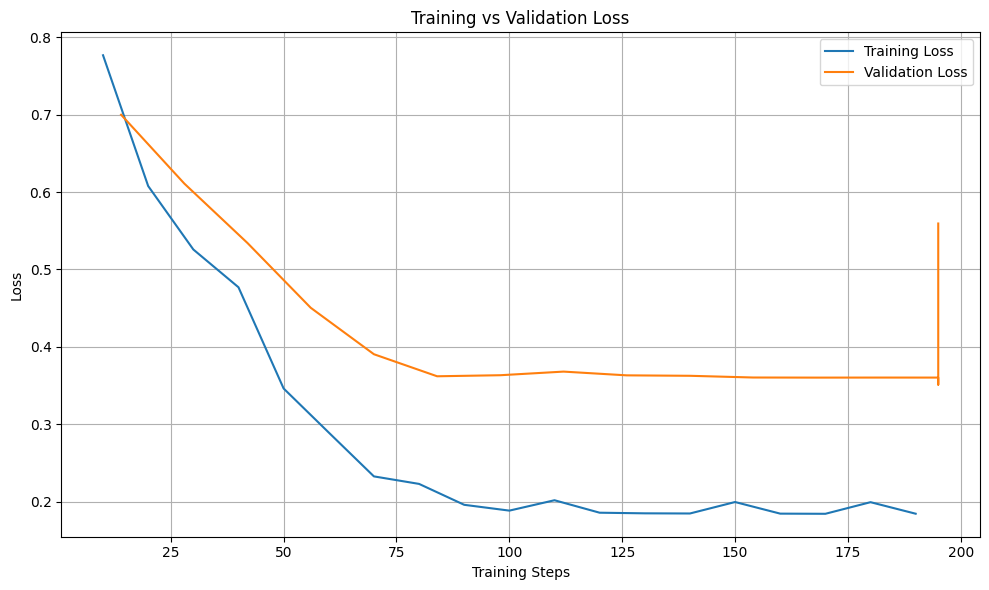

In [ ]:

train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
steps_train = [log["step"] for log in trainer.state.log_history if "loss" in log]
steps_eval = [log["step"] for log in trainer.state.log_history if "eval_loss" in log]

plt.figure(figsize=(10, 6))
plt.plot(steps_train, train_loss, label="Training Loss")
plt.plot(steps_eval, eval_loss, label="Validation Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.show()